In [1]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch.nn.functional as F
import scipy as sp

epochs = 200
n_tasks = 0
L = 0
gamma0 = 1
widths = [4196]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(123)
batch = 25
eta = 0.1

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 1, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                h1act = self.relu(h1)
                g = ( 1.0*(h1act>0) * torch.sum(self.fc2.weight.T, dim=1)).detach().clone()
                z = ( torch.sum(self.fc2.weight.T, dim=1)).detach().clone()
                h2 = self.fc2(h1act)/self.out_scale
            
                return h2, h1.detach().clone(), g, z

@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')
data = data[data['label'].isin([0, 1])]
test = test[test['label'].isin([0, 1])]

X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255
X = X[:batch]

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(1, device=device)[Y_temp]
Y = Y[:batch]
_ , indeces = torch.sort(Y_temp[:batch])
Y = Y[indeces]
X = X[indeces]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(1, device=device)[Y_temp]

tasks = [X]
tasks_test = [X_test]

for _ in range(n_tasks):
        perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))


def top_eigen(model, loss, X, Y, prt=False):

            hess_comp = hessian(model, loss, (X,Y) )
            top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
                
            return top_eigenvalues[-1] , top_eigenvector

def overlap(model, inputs, targets):
    
    gradients = torch.cat([param.grad.view(-1) for param in model.parameters()])
    params = torch.cat([param.data.view(-1) for param in model.parameters()])

    norm = torch.norm(params)

    def loss_fn(params):
        idx = 0
        layers = []
        for param in model.parameters():
            param_numel = param.numel()
            layers.append(params[idx:idx + param_numel].view_as(param))
            idx += param_numel
        relu = nn.ReLU()
        outputs = relu(inputs@layers[0].T) @ layers[1].T
        return MSE(outputs, targets)

    hvp = torch.autograd.functional.hvp(loss_fn, params, gradients)[1]
    return (torch.dot(hvp,gradients)/(torch.norm(hvp) * torch.norm(gradients))).item(), norm.item()

def loss_fn(predictions, targets):
    return F.nll_loss(predictions, targets)

def compute_grad(model, sample, target):
    sample = sample.unsqueeze(0)  # prepend batch dimension for processing
    target = target.unsqueeze(0)

    prediction = model(sample)
    loss = loss_fn(prediction, target)

    return torch.autograd.grad(loss, list(model.parameters()))


def compute_sample_grads(model, data, targets):
    """ manually process each sample with per sample gradient """
    sample_grads = [compute_grad(model, data[i], targets[i]) for i in range(len(X))]
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    return sample_grads

In [2]:
save_out = False
h = []
g = []
z = []

def loss_fn(predictions, targets):
    return F.mse_loss(predictions, targets)

for regime in ['mup']:
    for N in widths:

        loss_hist = []
        lam = []
        acc = []
        all = []
        norm = []
        delta1 = []
        #res2 = []
        
        mlp = MLP(N,L,regime, gamma0)
        lrs = {'sp':1,'ntk':1,'mup': eta*mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                            running_loss = 0.0
                        

                            # Batch of training 
                            #ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            #ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            #lt = []
                            #for s in range(t+1):
                            #    sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                            #    lt.append(sharp)
                            #lam.append(lt)    
                            #layers = [param.data for param in mlp.parameters()]
                            
                            out, ht, gt, zt = mlp(Xt)
                            #lossfn = loss_fn(out, Y)
                            
                            h.append(ht)

                            #grad = compute_sample_grads(mlp,X, Y)
                            g.append(gt)

                            z.append(zt)

                            optimizer.zero_grad()

                            loss = MSE(out, Y)*0.5
                            delta1.append(torch.sum(out-Y, dim=1))

                            loss.backward()
                           
                            running_loss += loss.item()

                            #over, no = overlap(mlp, X[ix], Y[ix])

                            #all.append(over)
                            #norm.append(no)
                            
                            optimizer.step()
                            loss_hist.append(loss.item())

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s])[0], dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct) 
                
        if save_out:        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/lamda{N}_{regime}.txt', 'w') as file:
            
                for lst in lam:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/acc{N}_{regime}.txt', 'w') as file:

                for lst in acc:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/overlap{N}_{regime}.txt', 'w') as file:

                for a in all:
                    file.write(str(a) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/norm{N}_{regime}.txt', 'w') as file:

                for n in norm:
                    file.write(str(n) + ' ')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4196]       3,289,664
              ReLU-2              [-1, 1, 4196]               0
            Linear-3                 [-1, 1, 1]           4,196
Total params: 3,293,860
Trainable params: 3,293,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 12.57
Estimated Total Size (MB): 12.63
----------------------------------------------------------------
Finished Training task0, train loss: 0.0006874363124370575


In [3]:
mlp = mlp.eval()

In [4]:
(torch.sum(torch.round(mlp(X_test)[0]) == Y_test)/len(Y_test)).item()

0.9612293243408203

In [5]:
a = mlp(X_test)

In [6]:
D = X.shape[1]
N = widths[0]
P = len(X)
K_x = X @ X.T / D
K_x = K_x.cpu()

In [7]:
def plot_dist(vecs, all=True, log= True):
    for vec in vecs:
        counts, bins = torch.histogram(vec.view(-1), bins=200)
        plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])))
        if not all:
            if log:
                plt.yscale('log')
            plt.grid()
            plt.show()
    if all:
        if log:
            plt.yscale('log')
        plt.grid()
        plt.show()

def compare(phi, phi2):
    fig, ax = plt.subplots(1,2)
    a1 = ax[0].imshow(phi, cmap='coolwarm')
    a2 = ax[1].imshow(phi2, cmap='coolwarm')
    plt.colorbar(a1)
    plt.colorbar(a2)
    plt.show()

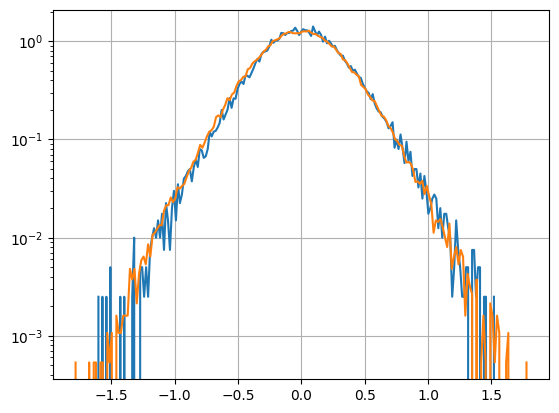

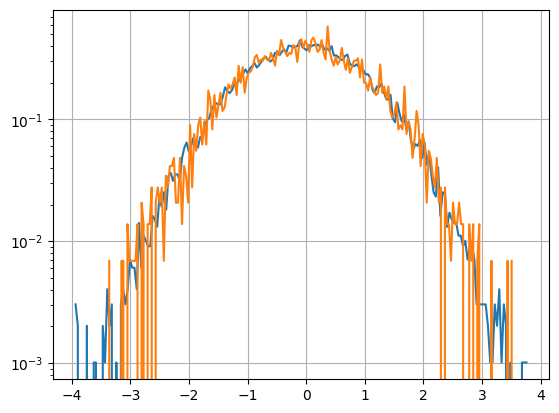

In [8]:
s = 1024
Chi = torch.distributions.MultivariateNormal(torch.zeros(len(X)), K_x).sample((s,))
Xi = torch.distributions.MultivariateNormal(torch.zeros(len(X)), torch.eye(len(X))).sample((s,))

plot_dist([Chi,h[0].cpu()])
plot_dist([Xi,z[0].cpu()])

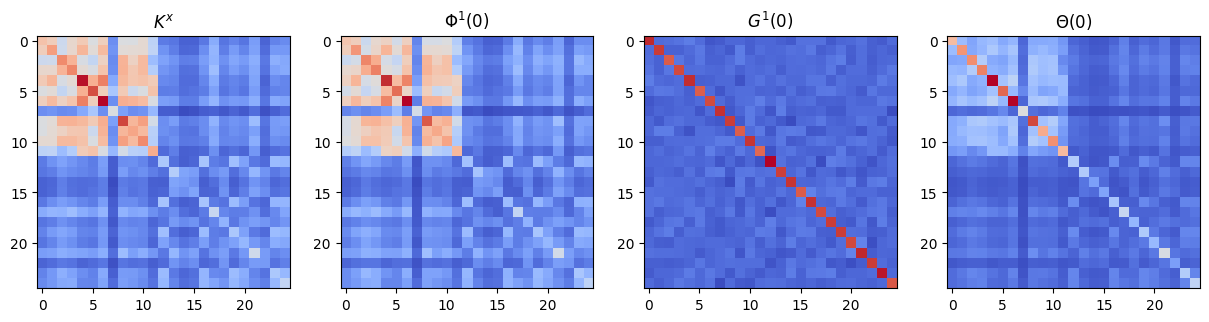

In [9]:
Phi_0 = Chi.T @ Chi / s
G_0 = Xi.T @ Xi / s

fig, ax = plt.subplots(1,4, figsize=(15,6))

ax[0].imshow(K_x.cpu(), cmap='coolwarm')
ax[0].set_title('$K^x$')

ax[1].imshow(Phi_0, cmap='coolwarm')
ax[1].set_title('$\Phi^1(0)$')

ax[2].imshow(G_0, cmap='coolwarm')
ax[2].set_title('$G^1(0)$')

ax[3].imshow(Phi_0 + G_0 * K_x, cmap='coolwarm')
ax[3].set_title('$\Theta(0)$')

plt.show()

In [10]:
n_steps = 50
def sampleChi(K, P, S):
    return torch.distributions.MultivariateNormal(torch.zeros(P), K).sample((S,))

# -----------------------------------------------------------------------------------------
def sampleXi(S):
    return torch.distributions.Normal(0,1).sample((S,))

# -----------------------------------------------------------------------------------------
#def SelfConsist(chi, xi, deltas, zs, hs, K, gamma0, eta, relu=True):
#    P = deltas[-1].shape[0]
#    hs.append(sampleChi(K,P,S))
#    zs.append(sampleXi(S))
#    for n in range(n_steps):
#        dh = 0
#        dz = 0
#        for z,h,delta in zip(zs,hs,deltas):
#            if relu:
#                g = torch.stack([z] * len(X), dim=1) * (h > 0)
#                h = h * (h > 0)  
#            else:
#                g = torch.stack([z] * len(X), dim=1)
#
#            dh +=  g @ (K * torch.stack([delta] * len(X), dim=1))
#            dz +=  h @ delta.T
#           # print(torch.mean(dh),torch.mean(dz))
#        h_up = chi + eta*gamma0/P*dh
#        z_up = xi + eta*gamma0/P*dz
#
#        loss = ( torch.sum((h_up-hs[-1])**2) + torch.sum((z_up-zs[-1])**2) )/ (torch.sum(hs[-1]**2) + torch.sum(zs[-1]**2) )
#        hs[-1] = h_up 
#        zs[-1] = z_up
#        if loss < 1e-9:
#           # print(loss)
#            return h_up, z_up
#
#    return h_up, z_up
    
def SelfConsist( delta, z, h, K, gamma0, eta, relu=True):
    P = delta.shape[0]
    if relu:
        g = torch.stack([z] * len(X), dim=1) * (h > 0)
        hact = h * (h > 0)  
    else:
        g = torch.stack([z] * len(X), dim=1)

    dh = g @ (K * torch.stack([delta] * len(X), dim=1))
    dz = hact @ delta.T

    h_up = h + eta*gamma0/P*dh
    z_up = z + eta*gamma0/P*dz

    return h_up, z_up

# -----------------------------------------------------------------------------------------
def get_Phi(h1,h2,relu=True):
    if relu:
        h1 = h1 * (h1>0)
        h2 = h2 * (h2>0)
    N = h1.shape[0]
    
    return h1.T @ h2 / N

# -----------------------------------------------------------------------------------------
def get_G(z1,z2, h1,h2, relu=True):
    N = z1.shape[0]
    if relu:
        g1 = torch.stack([z1] * len(X), dim=1) * (h1>0) 
        g2 = torch.stack([z2] * len(X), dim=1) * (h2>0)
    else:
        return z1.T @ z2 / N

    return g1.T @ g2 / N

# -----------------------------------------------------------------------------------------
def updateDelta(Phi, G, K, delta,eta):
    ntk = Phi + G * K
    del_new = delta - eta/P * ntk @ delta
        
    return del_new


In [11]:
S = 10000
beta = 1

hs = [sampleChi(K_x,P, S)]
zs = [sampleXi(S)]
Phis = [get_Phi(hs[-1],hs[-1])]
Gs = [get_G(zs[-1],zs[-1],hs[-1],hs[-1])]
deltas = [torch.sum(Y, dim=1).cpu()]

for i in range(epochs):

    h_up, z_up = SelfConsist(deltas[-1], zs[-1], hs[-1], K_x, gamma0, eta)

    delta_up = updateDelta(Phis[-1], Gs[-1], K_x, deltas[-1], eta)

    # update kernels 
    Phi_up = get_Phi(h_up,h_up)
    G_up = get_G(z_up, z_up, h_up, h_up)

    Phi_up = beta*Phi_up + (1-beta)*Phis[-1]
    G_up = beta*G_up + (1-beta)*Gs[-1]

    # appending section
    hs.append(h_up)
    zs.append(z_up)
    Phis.append(Phi_up)
    Gs.append(G_up)
    deltas.append(delta_up)


/var/folders/bf/nxgsxk9n0xvdy1w25bwdrpg80000gn/T/ipykernel_8212/3543654678.py:48: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3639.)
  dz = hact @ delta.T


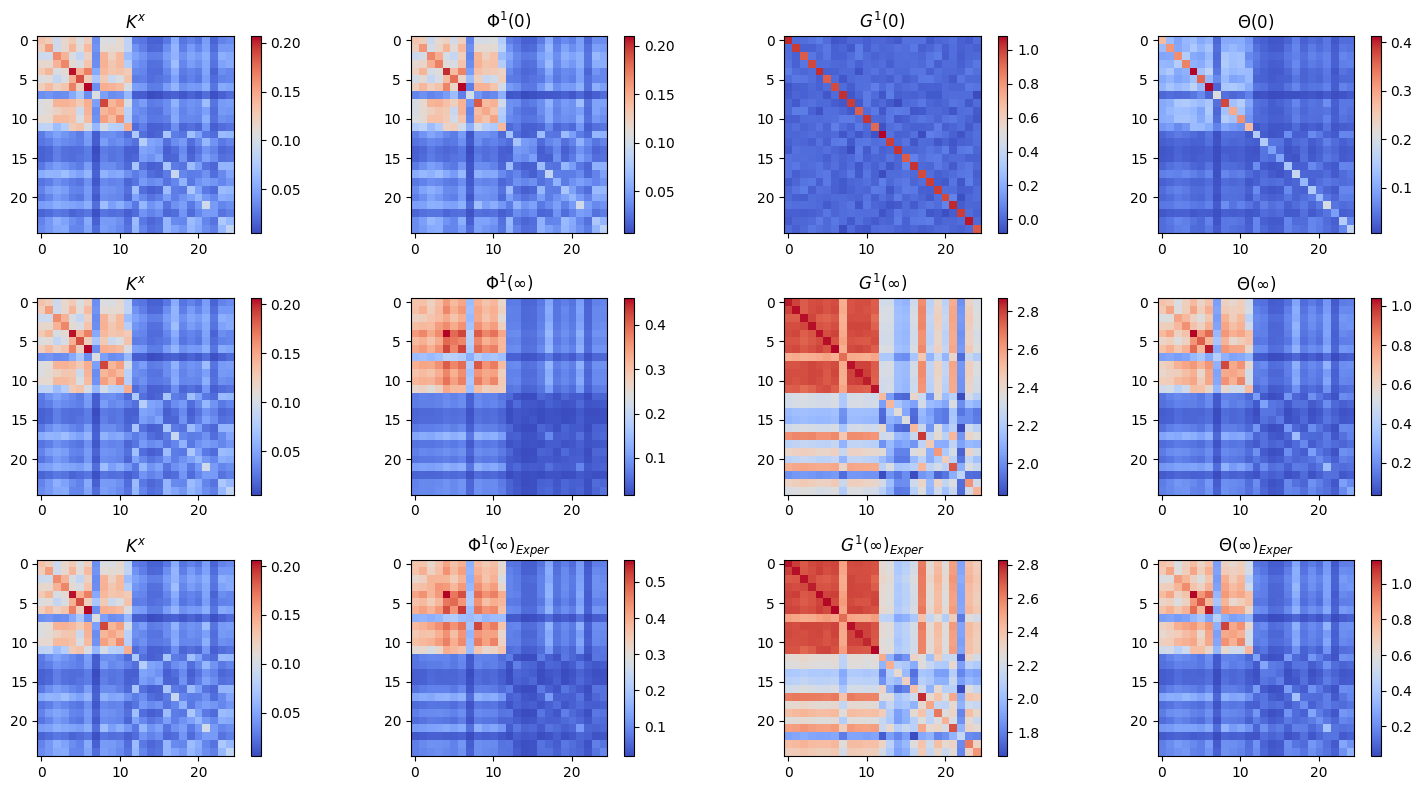

In [12]:
Phi_exp = h[-1] @ h[-1].T/N
G_exp = g[-1] @ g[-1].T/N

fig, ax = plt.subplots(3,4, figsize=(15,8))

ax1 = ax[0,0].imshow(K_x.cpu(), cmap='coolwarm')
ax[0,0].set_title('$K^x$')

ax2 = ax[0,1].imshow(Phi_0, cmap='coolwarm')
ax[0,1].set_title('$\Phi^1(0)$')

ax3 = ax[0,2].imshow(G_0, cmap='coolwarm')
ax[0,2].set_title('$G^1(0)$')

ax4 = ax[0,3].imshow(Phi_0 + G_0 * K_x, cmap='coolwarm')
ax[0,3].set_title('$\Theta(0)$')

ax5 = ax[1,0].imshow(K_x.cpu(), cmap='coolwarm')
ax[1,0].set_title('$K^x$')

ax6 = ax[1,1].imshow(Phis[-1], cmap='coolwarm')
ax[1,1].set_title('$\Phi^1(\infty)$')

ax7 = ax[1,2].imshow(Gs[-1], cmap='coolwarm')
ax[1,2].set_title('$G^1(\infty)$')

ax8 = ax[1,3].imshow(Phis[-1] + Gs[-1] * K_x.cpu(), cmap='coolwarm')
ax[1,3].set_title('$\Theta(\infty)$')

ax9 = ax[2,0].imshow(K_x.cpu(), cmap='coolwarm')
ax[2,0].set_title('$K^x$')

ax10 = ax[2,1].imshow(Phi_exp.cpu(), cmap='coolwarm')
ax[2,1].set_title('$\Phi^1(\infty)_{Exper}$')

ax11 = ax[2,2].imshow(G_exp.cpu(), cmap='coolwarm')
ax[2,2].set_title('$G^1(\infty)_{Exper}$')

ax12 = ax[2,3].imshow(Phi_exp.cpu() + G_exp.cpu() * K_x.cpu(), cmap='coolwarm')
ax[2,3].set_title('$\Theta(\infty)_{Exper}$')

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
for a in axes:
    plt.colorbar(a)
    
plt.tight_layout()
plt.show()

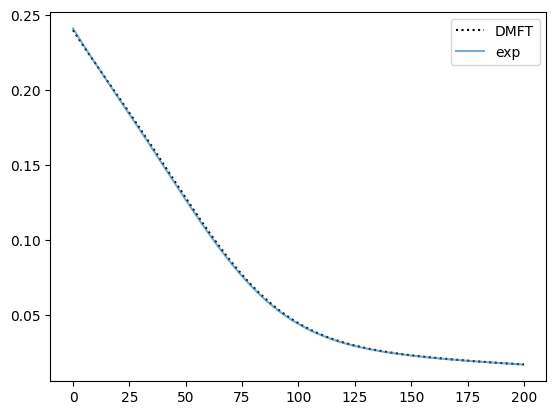

In [13]:
loss_th = []
for i in range(len(deltas)):
         loss_th.append(torch.mean(deltas[i]**2).item()/2)

plt.plot(loss_th, linestyle=':', color='black', label = 'DMFT')
plt.plot(loss_hist, alpha= 0.6, label='exp')
plt.legend()
plt.show()

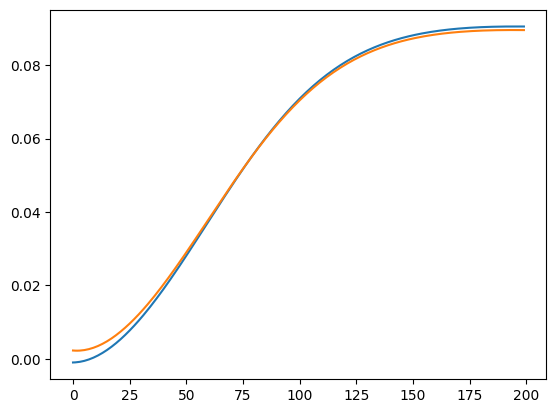

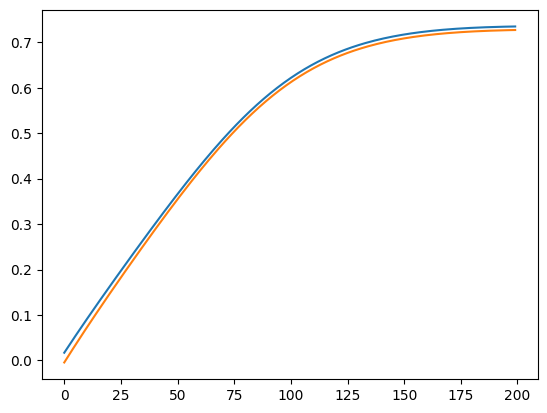

In [14]:
normh = []
normh_e = []
normg = []
normg_e = []

for i in range(epochs):
    normh.append(torch.mean(hs[i]))
    normh_e.append(torch.mean(h[i].cpu()))
    normg.append(torch.mean(zs[i]))
    normg_e.append(torch.mean(z[i].cpu()))

plt.plot(normh)
plt.plot(normh_e)
plt.show()
plt.plot(normg)
plt.plot(normg_e)

In [18]:
def compare_NTK(idxs):
    for idx in idxs:
        Phi_exp = h[idx] @ h[idx].T/N
        G_exp = g[idx] @ g[idx].T/N
        Phi_th = Phis[idx]
        G_th = Gs[idx]
        ntk_exp = (Phi_exp + G_exp*K_x.to(device)).cpu()
        ntk_th = (Phi_th.to(device) + G_th.to(device)*K_x.to(device)).cpu()
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].set_title('Expr')
        ax[1].set_title('Theory')
        exp = ax[0].imshow(G_exp.cpu(), cmap='coolwarm')
        th = ax[1].imshow(G_th.cpu(), cmap='coolwarm')
        plt.colorbar(exp)
        plt.colorbar(th)
        plt.show()

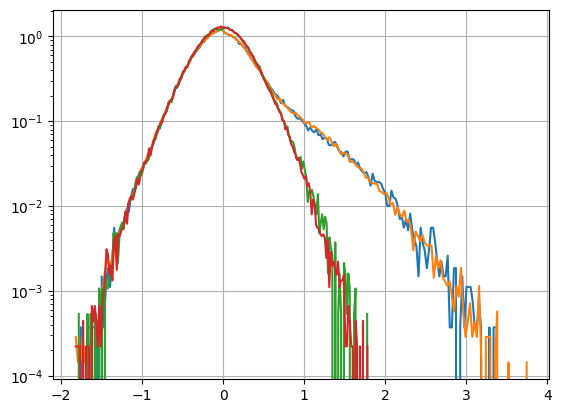

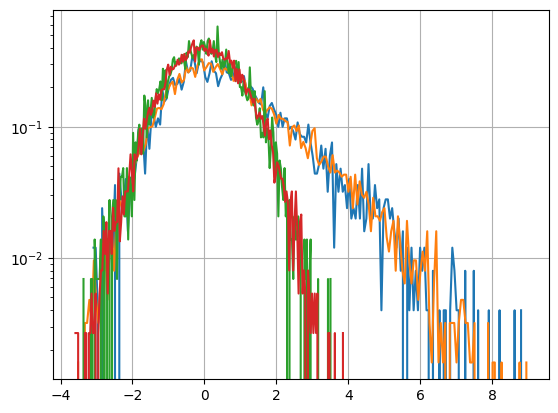

In [23]:
plot_dist([h[-1].cpu(), hs[-1],h[0].cpu(), hs[0]])
plot_dist([z[-1].cpu(), zs[-1],z[0].cpu(), zs[0]])

In [31]:
Phis_exp = []
Gs_exp = []
for i in range(epochs):
    Phis_exp.append(h[i].to(device) @ h[i].to(device).T/N)
    Gs_exp.append(g[i].to(device) @ g[i].to(device).T/N)

In [70]:
Phidyn_th = torch.empty((epochs,epochs))
Gdyn_th = torch.empty((epochs,epochs))
Phidyn_exp = torch.empty((epochs,epochs))
Gdyn_exp = torch.empty((epochs,epochs))

for i in range(epochs):
    for j in range(epochs):
        Phidyn_th[i,j] = torch.sum(Phis[i]*Phis[j])
        Gdyn_th[i,j] = torch.sum(Gs[i]*Gs[j])
        Phidyn_exp[i,j] = torch.sum( Phis_exp[i] * Phis_exp[j] )
        Gdyn_exp[i,j] = torch.sum(Gs_exp[i] * Gs_exp[j])

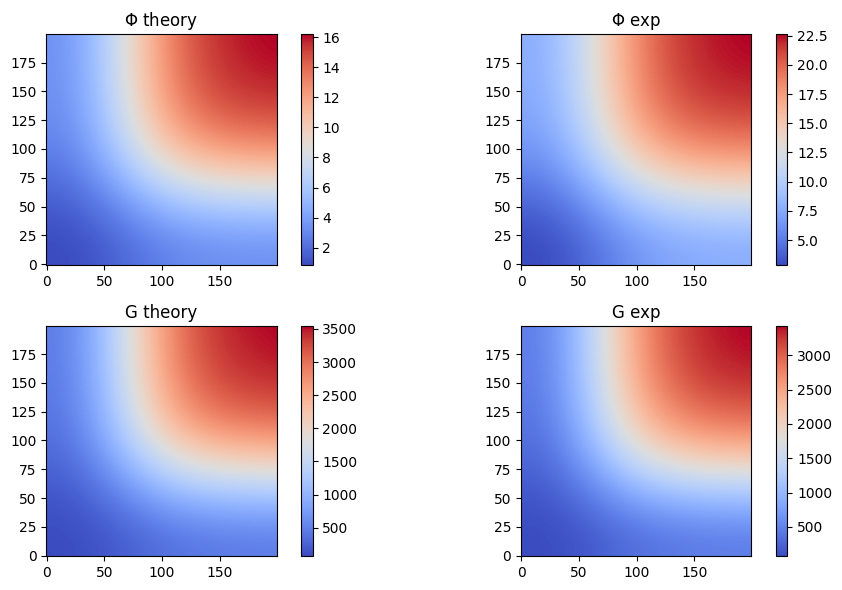

In [72]:
yticks = list(reversed(np.arange(0, epochs,50)))

fig, ax = plt.subplots(2,2, figsize=(10,6))
ax00 = ax[0,0].imshow(Phidyn_th, cmap='coolwarm', )
plt.colorbar(ax00)
ax[0,0].invert_yaxis()
ax[0,0].set_title('$\Phi$ theory')

ax01 = ax[0,1].imshow(Phidyn_exp, cmap='coolwarm')
plt.colorbar(ax01)
ax[0,1].invert_yaxis()
ax[0,1].set_title('$\Phi$ exp')

ax10 = ax[1,0].imshow(Gdyn_th, cmap='coolwarm')
plt.colorbar(ax10)
ax[1,0].invert_yaxis()
ax[1,0].set_title('G theory')

ax11 = ax[1,1].imshow(Gdyn_exp, cmap='coolwarm')
plt.colorbar(ax11)
ax[1,1].invert_yaxis()
ax[1,1].set_title('G exp')

plt.tight_layout()


In [17]:
HLT

NameError: name 'HLT' is not defined

In [ ]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch.nn.functional as F
import scipy as sp

epochs = 20
n_tasks = 0
L = 0
gamma0 = 1
widths = [1024]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(123)
batch = 100

P = 25
D = 40
X = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample((P,))
Y = -1.0*np.ones(P)
Y[0:P//2]= np.ones(P//2)